<a href="https://colab.research.google.com/github/ck1972/University-GeoAI/blob/main/Lab_2b_Modeling_AGBD_GEDI_S2_SI_MafungautsiForestReserve_Comparison_ML_Regressors_Scikit_Learn_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No Free Lunch: Comparing Machine Learning Regression Methods to Estimate AGBD

## Aim
In the previous tutorial, we observed a significant improvement in the validation RMSE and R-squared values, suggesting a reduction in model overfitting. This tutorial compares machine learning regression methods such as K-nearest neighbor (KNN), support vector regression (SVR), decision trees, random forests, histogram-gradient boosting, and artificial neural networks (ANNS). By comparing machine learning regression methods thoroughly, researchers can make more informed choices about which approaches to use for forest AGBD estimation, empowering them to make significant contributions to the field of forest biomass assessment.

In this tutorial, we will utilize Scikit-Learn, a comprehensive and widely used machine learning library in Python. Scikit-Learn offers a broad range of machine learning methods and algorithms, providing greater flexibility and functionality compared to Earth Engine's built-in capabilities. The Scikit-Learn libraries allow us to tune and customize our models for better accuracy and performance.

## Requirements
To run this script, the user must have an Earth Engine account and authenticate the Earth Engine Python API. See the instructions [here](https://developers.google.com/earth-engine/guides/auth). Following are the steps to model AGBD.

# Initialize and Authenticate Earth Engine
To get started with Google Earth Engine (GEE), you need to initialize and authenticate the Earth Engine API. Follow these steps.


First, import the Earth Engine API by importing the ee module into your Python environment. This module allows you to interact with the Earth Engine platform.


In [ ]:
# Import the API
import ee

Next, initialize the Earth Engine API. You must initialize the API to use Earth Engine functionalities. This involves authenticating your session and initializing the library. When you run the ee.Initialize() command for the first time, you might be prompted to authenticate your session. This will open a web browser window where you need to log in with your Google account and grant Earth Engine access.

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-kamusoko-test')

## Install and import libraries
Next, install the required libraries.

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.3 MB/s eta 0:00:00


Import the essential libraries needed to process and analyze the datasets.

In [ ]:
# Import the necessary libraries
import geemap
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import earthpy.plot as ep
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import time

## Prepare predictor variables
This tutorial will use predictor variables such as Sentinel-2, the normalized difference vegetation index (NDVI), the soil-adjusted vegetation index (SAVI), the red edge spectral index (RESI), elevation, and slope.

### Import the project boundary
First, import the forest reserve project boundary from the Google Earth Engine catalog's World Database on Protected Areas ('WCMC/WDPA/current/polygons'). The World Database on Protected Areas (WDPA) is the most up-to-date and comprehensive source of information on protected areas, updated monthly with submissions from governments, non-governmental organizations, landowners, and communities. It is managed by the United Nations Environment Programme's World Conservation Monitoring Centre (UNEP-WCMC) with support from the IUCN and its World Commission on Protected Areas (WCPA). Select your project forest reserve or protected area from the WDPA database.

Source: https://developers.google.com/earth-engine/datasets/catalog/WCMC_WDPA_current_polygons




In [ ]:
# Define the boundary for Mafungabusi forest reserve
boundary = ee.FeatureCollection('WCMC/WDPA/current/polygons') \
    .filter(ee.Filter.inList('NAME', ['Mafungabusi']))

### Create Sentinel-2 composite
Next, load Sentinel-2 spectral reflectance data from the COPERNICUS 'S2_SR_HARMONIZED' image collection in Earth Engine. First, we'll define a cloud-masking function called maskS2clouds. This function uses the QA60 band to identify clouds and cirrus clouds, masking out these cloudy pixels by setting specific bits to zero. The data is scaled by dividing by 10,000 to ensure accurate reflectance values.

Next, we will set our study period from January 1, 2022, to April 30, 2022, which captures the peak vegetation growth in our project area. We will filter the Sentinel-2 data for this period, retaining only images with less than 20% cloud cover. The maskS2clouds function will be applied to these filtered images, and we will select specific bands necessary for our analysis.

To create the composite image, we will compute the median value for each pixel across the filtered and masked dataset. This median composite is clipped to a predefined boundary, focusing on our area of interest. Finally, we will initialize a map centered on our boundary area and add the median composite image to the map using the selected bands (B11, B8, and B3). The map includes interactive layer control, allowing for easy exploration of the composite image.


In [ ]:
# Load Sentinel-2 spectral reflectance data.
s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')

# Create a function to mask clouds using the Sentinel-2 QA band.
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = ee.Number(2).pow(10).int()
    cirrusBitMask = ee.Number(2).pow(11).int()
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    # Return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

# Create a single composite image for a given period.
start_date = '2022-01-01'
end_date = '2022-04-30'

# Filter clouds from Sentinel-2 for the given period.
composite = s2.filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(maskS2clouds) \
    .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12'])  # Select bands for display

# Compute the median composite and clip to the boundary.
S2_composite = composite.median().clip(boundary)

# Initialize our map.
map1 = geemap.Map()
map1.centerObject(boundary, 12)

# Add the composite image to the map with specified display settings.
map1.addLayer(S2_composite, {'bands': ['B11', 'B8', 'B3'], 'min': 0, 'max': 0.3}, 'Sentinel-2 Composite')

# Display the map with layer control.
map1.addLayerControl()
map1

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

### Compute spectral indices
Next, calculate NDVI, SAVI, and RESI from the Sentinel-2 composite. The spectral indices provides more information about vegetation in the project area.

In [ ]:
# Calculate NDVI
ndvi = S2_composite.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Calculate SAVI.
L = 0.5  # Soil adjustment factor, typically between 0 and 1
savi = S2_composite.expression(
    '((NIR - Red) / (NIR + Red + L)) * (1 + L)', {
        'NIR': S2_composite.select('B8'),
        'Red': S2_composite.select('B4'),
        'L': L
    }).rename('SAVI')

# Calculate RESI
resi = S2_composite.expression(
    '((RE3 + RE2 - RE1) / (RE3 + RE2 + RE1))', {
        'RE1': S2_composite.select('B5'),
        'RE2': S2_composite.select('B6'),
        'RE3': S2_composite.select('B7')
    }).rename('RESI')

# Initialize our map.
map2 = geemap.Map()
map2.centerObject(boundary, 12)

# Add the NDVI and RESI layers to the map.
map2.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
map2.addLayer(savi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'SAVI')
map2.addLayer(resi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'RESI')

# Display the map with layer control.
map2.addLayerControl()
map2

Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

### Load other datasets
Elevation and slope are crucial for modeling forest AGBD density due to their significant impact on environmental conditions, topographic effects, soil moisture, nutrient availability, species composition, human influence, and predictive power. Elevation affects temperature and precipitation, altering the conditions trees experience and leading to variations in AGBD. Slope and elevation also explain spatial variations in biomass distribution within landscapes, influence soil moisture and nutrient availability, and affect tree growth. Different species adapt to specific elevation ranges and slope conditions, leading to changes in AGBD. Human activities, more common in accessible lower elevations and gentler slopes, can reduce biomass density. Topographic attributes like elevation and slope strongly predict AGBD in machine learning models. Additionally, elevation and slope interact with other environmental factors to create complex biomass distribution patterns and microclimates, significantly influencing local growing conditions and biomass accumulation. Including elevation and slope data in AGBD models enables researchers to capture these topographic influences, resulting in more accurate estimates of forest carbon stocks and productivity.


Next, import other datasets, such as the Shuttle Radar Topography Mission (SRTM) digital elevation model (DEM). Add the SRTM DEM data and calculate the slope.


In [ ]:
# Load SRTM DEM
SRTM = ee.Image("USGS/SRTMGL1_003")

# Clip Elevation to the boundary
elevation = SRTM.clip(boundary)

# Derive slope from the SRTM
slope = ee.Terrain.slope(SRTM).clip(boundary)

# Compute the minimum and maximum elevation values within the boundary.
min_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

max_elevation = elevation.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=boundary,
    scale=30,
    maxPixels=1e9
).get('elevation').getInfo()

print(f"Min Elevation: {min_elevation}, Max Elevation: {max_elevation}")

# Initialize our map.
map3 = geemap.Map()
map3.centerObject(boundary, 12)

# Define attractive color gradients for elevation and slope
elevationPalette = ['006633', '99cc00', 'ffff00', 'ff9900', 'ff6600', 'ff3333', 'ff0000', 'cc0000', '990000', '660000', '330000', '000000']
slopePalette = ['440154', '482878', '3E4A89', '31688E', '26838F', '1F9D8A', '6CCE59', 'B6DE2B', 'FDE724']

# Add elevation layer to the map with new palette
vis_params_elevation = {'min': min_elevation, 'max': max_elevation, 'palette': elevationPalette}
map3.addLayer(elevation, vis_params_elevation, 'Elevation')

# Add slope layer to the map with new palette
vis_params_slope = {'min': 0, 'max': 60, 'palette': slopePalette}
map3.addLayer(slope, vis_params_slope, 'Slope')

# Display the map with layer control.
map3.addLayerControl()
map3

Min Elevation: 1112, Max Elevation: 1341


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

### Merge all predictor variables
Combine Sentinel-2 bands, spectral indices (NDVI, SAVI, RESI), elevation (SRTM DEM), and slope. Ensure all bands have the same data type ( e.g., Float32). You can apply the casting function to all image variables before merging them.

In [ ]:
# Function to cast image bands to Float32
def cast_to_float32(image):
    return image.toFloat()

# Cast all images to Float32
S2_composite = cast_to_float32(S2_composite)
ndvi = cast_to_float32(ndvi)
savi = cast_to_float32(savi)
resi = cast_to_float32(resi)
elevation = cast_to_float32(elevation)
slope = cast_to_float32(slope)

# Define the merged collection
mergedCollection = (
    S2_composite
    .addBands(ndvi)
    .addBands(savi)
    .addBands(resi)
    .addBands(elevation)
    .addBands(slope)
)

# Clip the output image to the farm boundary
clippedmergedCollection = mergedCollection.clipToCollection(boundary)

### Export predictor variables to Google Drive
Next, we need to export our predictor variables to Google Drive. These predictor variables include the Sentinel-2 bands, NDVI, SAVI, and RESI, elevation and the slope. By exporting these predictor variables to Google Drive, we can easily access and use them in our machine learning workflows with Scikit-Learn.


In [ ]:
# Export the training data to Google Drive
task = ee.batch.Export.image.toDrive(**{
    'image': clippedmergedCollection,
    'description': 'S2_predictors_2022',
    'folder': 'Maf_datasets',
    'fileNamePrefix': 'S2_predictors_2022',
    'region': boundary.geometry().bounds().getInfo()['coordinates'],
    'scale': 30,
    'fileFormat': 'GeoTIFF'
})

task.start()

print("Exporting the training data to Google Drive. This may take a while...")

# Wait for the export to finish before proceeding with the local processing
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(30)

print("Export completed.")

Exporting the training data to Google Drive. This may take a while...
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Polling for task (id: OQW4VBPMWXM344MV4SYBH4JG).
Export completed.


## Prepare the response variable
### Extract AGBD from GEDI Level 4A
Derive aboveground biomass density (AGBD) from the GEDI Level 4A (L4A) dataset. This dataset contains AGBD predictions in Mg/ha. More information about this dataset is available at: https://developers.google.com/earth-engine/datasets/catalog/LARSE_GEDI_GEDI04_A_002.


This tutorial will process the GEDI Level 4A dataset to filter and enhance the quality of aboveground biomass density (AGBD) measurements. The dataset is loaded from the Earth Engine collection LARSE/GEDI/GEDI04_A_002_MONTHLY. The script defines three functions for masking unreliable data to ensure data quality. The quality_mask function selects only the highest quality GEDI data by masking pixels where the l4_quality_flag is not equal to 1, and the degrade_flag is not equal to 0. The error_mask function masks GEDI measurements with a relative standard error greater than 50%. It calculates the relative standard error by dividing the AGBD standard error (agbd_se) by the AGBD (agbd) and masks values where this relative error exceeds 0.5. Lastly, the slope_mask function masks GEDI measurements on slopes greater than 30%. It loads the SRTM digital elevation model (USGS/SRTMGL1_003) and calculates the slope using the ee.Terrain.slope function, and masks areas where the slope is 30% or more. These masking functions ensure that only high-quality and reliable data is used in further analyses.

In [ ]:
# Select a time-period
start_date = ee.Date.fromYMD(2022, 1, 1)
end_date = ee.Date.fromYMD(2022, 5, 30)

# Load the GEDI Level 4A dataset
gedi = ee.ImageCollection('LARSE/GEDI/GEDI04_A_002_MONTHLY')

# Function to select highest quality GEDI data
def quality_mask(image):
    return image.updateMask(image.select('l4_quality_flag').eq(1)) \
                .updateMask(image.select('degrade_flag').eq(0))

# Function to mask unreliable GEDI measurements with a relative standard error > 50%
def error_mask(image):
    relative_se = image.select('agbd_se').divide(image.select('agbd'))
    return image.updateMask(relative_se.lte(0.5))

# Function to mask GEDI measurements on slopes > 30%
def slope_mask(image):
    # Load the SRTM digital elevation model
    srtm = ee.Image('USGS/SRTMGL1_003')

    # Calculate slope
    slope = ee.Terrain.slope(srtm)

    return image.updateMask(slope.lt(30))

# Apply the filters
gedi_filtered = gedi.filter(ee.Filter.date(start_date, end_date)) \
                    .filter(ee.Filter.bounds(boundary))

gedi_projection = ee.Image(gedi_filtered.first()).select('agbd').projection()

gedi_processed = gedi_filtered.map(quality_mask).map(error_mask).map(slope_mask)

# Create a mosaic of the filtered images
gedi_mosaic = gedi_processed.mosaic().select('agbd').setDefaultProjection(gedi_projection).clip(boundary)

# Create the display parameters
gediVis = {
    'min': 1,
    'max': 300,
    'palette': 'red, green, blue',
}

# Sample the training points (ta) from the dataset
points = gedi_mosaic.sample(
    region=boundary,
    scale=10,
    geometries=True
)

# Get the AGDB values from the 'agbd' property of the filtered points
agbd_values = points.aggregate_array('agbd').getInfo()

# Calculate summary statistics
mean_agbd = np.mean(agbd_values)
median_agbd = np.median(agbd_values)
std_agbd = np.std(agbd_values)
min_agbd = np.min(agbd_values)
max_agbd = np.max(agbd_values)

# Print the summary statistics
print("Mean AGBD:", mean_agbd)
print("Median AGBD:", median_agbd)
print("Standard Deviation AGBD:", std_agbd)
print("Minimum AGBD:", min_agbd)
print("Maximum AGBD:", max_agbd)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(points.size().getInfo())
print(points.first().getInfo())

Mean AGBD: 55.95385193846435
Median AGBD: 54.02808380126953
Standard Deviation AGBD: 24.650899229867175
Minimum AGBD: 6.068545818328857
Maximum AGBD: 228.418274
33408
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.640770214066315, -18.489228451542026]}, 'id': '0', 'properties': {'agbd': 28.594026565551758}}


### Display GEDI Level 4A AGBD
Next, display GEDI AGBD sample points.

In [ ]:
# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map4 = geemap.Map()
map4.centerObject(boundary, 12)
map4.addLayer(gedi_mosaic, gediVis, 'GEDI L4A Mean AGBD points')
map4.addLayer(points, {'color': '808080'}, 'Mean AGBD training points')

# Display the map
display(map4)

The provided color (red, green, blue) is invalid. Using the default black color.
'#red, green, blue' is not in web format. Need 3 or 6 hex digit.


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

Next, create density and box plots for the GEDI L4A datasets using the seaborn library for density plots and matplotlib for box plots.

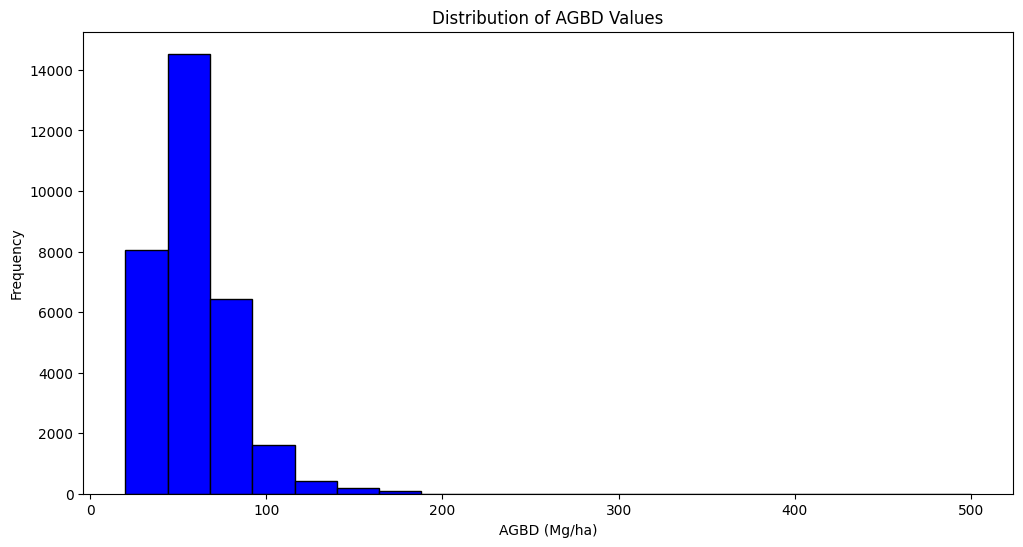

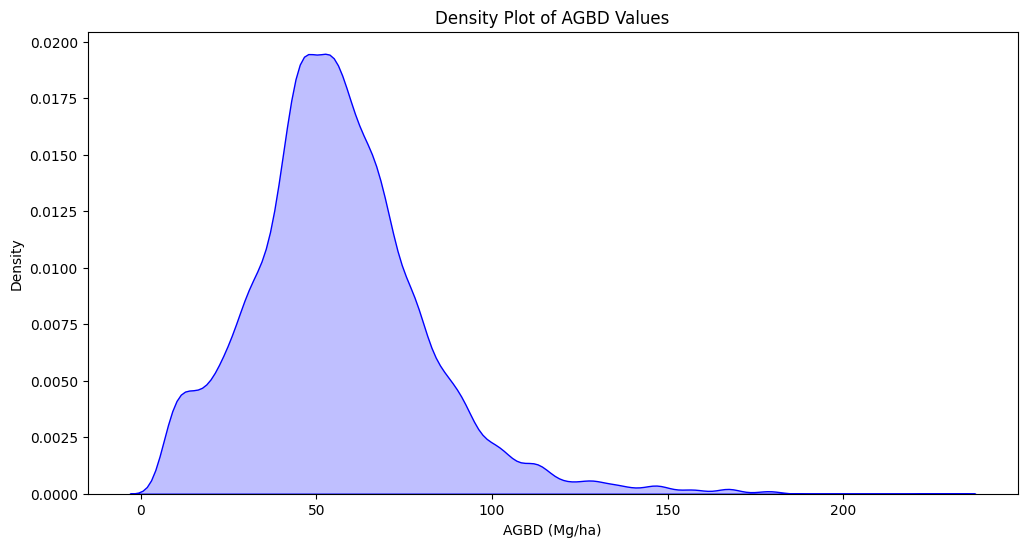

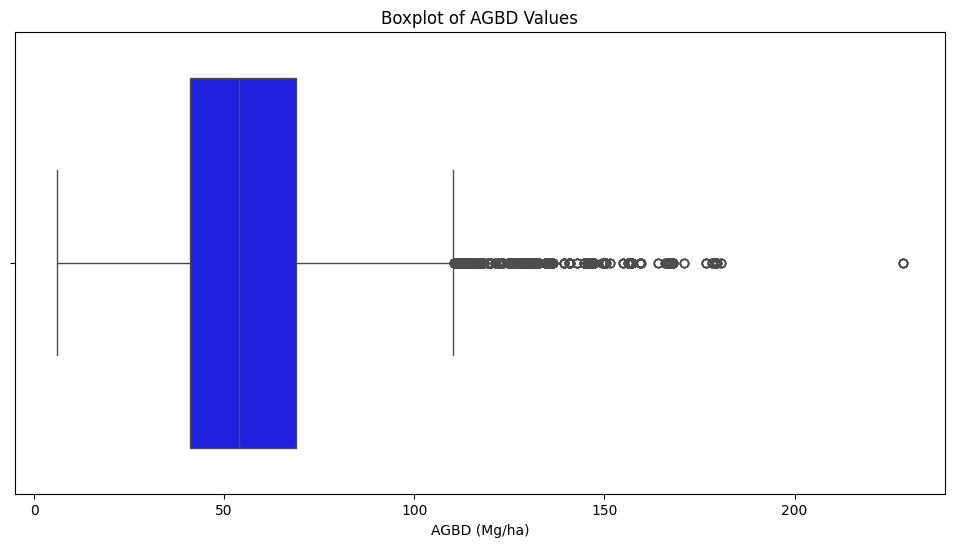

In [ ]:
# Plot a histogram of AGDB values
plt.figure(figsize=(12, 6))
plt.hist(agbd_values, bins=20, range=[20, 500], color='blue', edgecolor='black')
plt.xlabel('AGBD (Mg/ha)')
plt.ylabel('Frequency')
plt.title('Distribution of AGBD Values')
plt.show()

# Plot a density plot of AGDB values using seaborn
plt.figure(figsize=(12, 6))
sns.kdeplot(agbd_values, shade=True, color='blue')
plt.xlabel('AGBD (Mg/ha)')
plt.ylabel('Density')
plt.title('Density Plot of AGBD Values')
plt.show()

# Plot a boxplot of AGDB values using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x=agbd_values, color='blue')
plt.xlabel('AGBD (Mg/ha)')
plt.title('Boxplot of AGBD Values')
plt.show()

#### Notes
The histogram, density plot, and box plot together illustrate the distribution of Above Ground Biomass Density (AGBD) values derived from the GEDI Level 4A dataset.
The histogram shows that most AGBD values are concentrated at the lower end of the spectrum, primarily between 0 and 90 Mg/ha, with a steep drop-off in frequency as AGBD values increase. This right-skewed distribution suggests that low-b biomass areas are much more common than high-b biomass areas in the dataset.
The density plot plays a pivotal role in our analysis, serving as a visual confirmation of the skewness of the AGBD values. It shows a high peak at the lower AGBD values around 0-50 Mg/ha, followed by a gradual decline in density as the AGBD values increase. The smooth curve of the density plot helps to visualize the continuous distribution of AGBD values and highlights the presence of a long tail extending toward higher values, reassuring us about the accuracy of our analysis.
The box plot is a powerful tool in our analysis, providing a comprehensive and clear summary of the statistical distribution. The central line within the box indicates the median AGBD value, which represents the interquartile range (IQR). Most of the data lies within this range, while the whiskers extend to the minimum and maximum values within 1.5 times the IQR. Several outliers are visible beyond the whiskers, indicating some areas with significantly higher AGBD values, up to around 175 Mg/ha.
These plots collectively show that the GEDI Level 4A dataset predominantly features lower AGBD values with fewer high biomass densities. Outliers and the long tail in the density plot suggest occasional high biomass areas that stand out against the more common low biomass regions.

### Data cleaning

Next, we will filter the data points to retain aboveground biomass density (AGBD) values within 0 to 90 megagrams per hectare (Mg/ha). This range is determined based on the exploratory analysis of the extracted GEDI L4A AGBD sample points. By setting this range, we ensure that our dataset includes only realistic and relevant AGBD values, excluding any potential outliers or erroneous data points that could negatively impact our analysis.
Filtering the points within this specific AGBD range helps maintain data quality and consistency, which is crucial for accurate modeling and analysis. It allows us to focus on the most relevant portion of the data, reducing noise and improving the performance of subsequent machine learning models. Additionally, this step helps prevent the inclusion of extreme values that could skew the results and lead to inaccurate predictions.
Overall, this filtering process is essential to data cleaning, ensuring that the data we use for modeling AGBD is reliable and robust.

In [ ]:
# Filter the training points by range (0 Mg/ha to 100 Mg/ha)
filteredPoints = points.filter(
    ee.Filter.And(
        ee.Filter.gte('agbd', 0),
        ee.Filter.lte('agbd', 90)
    )
)

# Print and display the training (ta) points derived from the GEDI L4B dataset
print(filteredPoints.size().getInfo())
print(filteredPoints.first().getInfo())

# Display the GEDI L4A mean above-ground biomass (AGB) points and the derived training points
# Initialize the map
map5 = geemap.Map()
map5.centerObject(boundary, 12)
map5.addLayer(filteredPoints, {'color': '808080'}, 'Mean fitered AGBD training points')
# Display the map
display(map5)

30785
{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Point', 'coordinates': [28.640770214066315, -18.489228451542026]}, 'id': '0', 'properties': {'agbd': 28.594026565551758}}


Map(center=[-18.43596873133084, 28.869046137098042], controls=(WidgetControl(options=['position', 'transparent…

## Sampling training data in Google Earth Engine
We will select specific bands from the 'clippedmergedCollection' and then sample the values (spectral reflectance values) at the locations of the 'trainingData' points. First, define a list of bands to be extracted, including bands B2 through B8, B11, B12, and several indices such as NDVI, SAVI, and RESI, as well as topographical attributes like elevation and slope. Next, sample these selected bands at the locations specified by 'filteredPoints', which is a FeatureCollection containing the training points. The 'agbd' property from these points is used as the label for the sampled data. The sampling is performed at a resolution of 50 meters.


In [ ]:
# Select specific bands or variables from the 'clippedmergedCollection'
predictor_vars = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'SAVI', 'RESI', 'elevation', 'slope']
# Sample the values at the locations of the 'trainingData' points.
trainingData = clippedmergedCollection.select(predictor_vars).sampleRegions(**{
    'collection': filteredPoints,  # The 'trainingData' is the FeatureCollection containing training points.
    'properties': ['agbd'],  # The property 'agbd' is used as the label for the training points.
    'scale': 50  # The scale (resolution) at which the sampling is performed (in meters).
})

## Export training data to Google Drive
Next, we will export the training data to your Google Drive since we want to use machine learning algorithms available in Scikit Learn. This procedure takes time, depending on the size of the training data. The code initiates the export task by using the 'ee.batch.Export.table.toDrive' function to export the 'trainingData' as a CSV file to a folder named 'Maf_datasets' on Google Drive, with the description 'TA_AGDD_GEDI_L4A_2022'. The task is started, and a message is printed to indicate the beginning of the export process.


In order to ensure the export completes before proceeding with local processing, the time module is imported, and a loop is used to check the status of the export task. The loop prints the task's status every 30 seconds using the 'task.id' to identify the task. Once the export is complete, a final message will confirm its completion.

In [ ]:
# Export the training data to Google Drive
task = ee.batch.Export.table.toDrive(**{
    'collection': trainingData,
    'description': 'TA_AGDD_GEDI_L4A_2022',
    'folder': 'Maf_datasets',
    'fileFormat': 'CSV'
})

task.start()

print("Exporting the training data to Google Drive. This may take a while...")

# Import the time module
import time

# Wait for the export to finish before proceeding with the local processing
while task.active():
    print('Polling for task (id: {}).'.format(task.id))
    time.sleep(30)

print("Export completed.")

Exporting the training data to Google Drive. This may take a while...
Polling for task (id: UGE24PPZ27N5GEJU4ATIT22Y).
Polling for task (id: UGE24PPZ27N5GEJU4ATIT22Y).
Polling for task (id: UGE24PPZ27N5GEJU4ATIT22Y).
Export completed.


## Import training data
### Mount Google drive
We need to import training data that comprises the response and predictor variables (images). Let's start by mounting your Google Drive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the merged predictor variables
Next, we will set the path to the image file. The image is then loaded using the 'rasterio' library, which allows reading and handling of raster data. Several properties of the image are retrieved, including the number of bands (bandNum), image dimensions (height and width), coordinate reference system (CRS), and the transformation matrix (transform). These properties define the spatial and structural characteristics of the image. To visualize the Sentinel-2 bands, we will select bands 5, 6, and 4. These bands are read from the image and stacked together to create a three-band image suitable for visualization.

Finally, the stacked bands are plotted as an RGB image using the 'earthpy.plot' function. The plot is configured to be 8x8 inches, and the stretch parameter is set to True to enhance the contrast of the image for better visualization. This step ensures that the Sentinel-2 bands are correctly loaded and displayed, allowing for a quick visual check of the data.

/usr/local/lib/python3.10/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


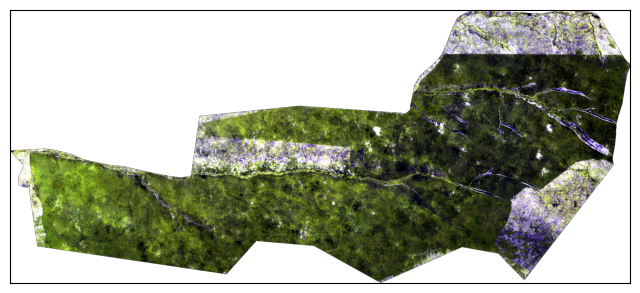

<Axes: >

In [ ]:
# Set the image path
image_path = '/content/drive/My Drive/Maf_Datasets/S2_predictors_2022.tif'

# Load image
image = rasterio.open(image_path)
bandNum = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform
shape = (height, width)

image_vis = []
for x in [5, 6, 4]:
  image_vis.append(image.read(x))
image_vis = np.stack(image_vis)

plot_size = (8, 8)
ep.plot_rgb(
  image_vis,
  figsize=plot_size,
  stretch=True,
)

### Load the training samples
Next, we will load the training samples (comprising GEDI L4A and predictor variables) into a pandas data frame. This step involves reading the data from a specified file (csv) where the training samples are stored and converting it into a 'DataFrame' format, which is a robust data structure provided by the pandas library in Python.

The pandas 'DataFrame' allows us to manipulate, analyze, and visualize the data easily. It provides functionalities for handling missing values, filtering data, performing statistical analyses, and more. By loading the training samples into a 'DataFrame,' we can leverage these capabilities to prepare the data for machine learning models.

In [ ]:
# Load GEDI L4A AGBD dataset
data = pd.read_csv('/content/drive/My Drive/Maf_Datasets/TA_AGDD_GEDI_L4A_2022.csv')
# Display the first few rows of the DataFrame to verify the data
print(data.head())

  system:index     B11     B12      B2      B3      B4      B5      B6  \
0          0_0  0.1946  0.1110  0.0488  0.0625  0.0496  0.0914  0.2010   
1          1_0  0.1946  0.1110  0.0488  0.0625  0.0496  0.0914  0.2010   
2          2_0  0.2151  0.1127  0.0478  0.0624  0.0502  0.0934  0.2411   
3          3_0  0.2100  0.1089  0.0485  0.0644  0.0501  0.0935  0.2320   
4          4_0  0.2100  0.1089  0.0485  0.0644  0.0501  0.0935  0.2320   

       B7       B8      NDVI      RESI      SAVI       agbd  elevation  \
0  0.2426  0.24125  0.658931  0.658318  0.363501  28.594027       1241   
1  0.2426  0.24125  0.658931  0.658318  0.363501  28.594027       1241   
2  0.2870  0.28900  0.704009  0.699437  0.426835  28.392700       1231   
3  0.2705  0.27500  0.691787  0.686242  0.408860  28.392700       1230   
4  0.2705  0.27500  0.691787  0.686242  0.408860  28.392700       1230   

     slope                                    .geo  
0  1.34759  {"type":"MultiPoint","coordinates":[]}  
1  1

Next, we will define our predictor and response variables for the machine learning model. The predictor variables, stored in the 'predictor_vars' list, include the Sentinel-2 spectral bands (B2, B3, B4, B5, B6, B7, B8, B11, and B12), spectral indices (NDVI, SAVI, and RESI), and topographic features (elevation and slope). These predictor variables are expected to influence the response variable, which is the aboveground biomass density (AGBD), stored in 'response_var'.
We then create two separate datasets from our primary data: X, which contains the predictor variables, and y, which includes the response variable. We use the panda's data frame indexing, where data[predictor_vars] extracts the columns corresponding to the predictor variables, and data[response_var] extracts the column corresponding to the response variable. We will use the X and y datasets to train our machine learning models..


In [ ]:
# Define predictor and response variables
predictor_vars = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12', 'NDVI', 'SAVI', 'RESI', 'elevation', 'slope']
response_var = 'agbd'
X = data[predictor_vars]
y = data[response_var]

## Split into training and test data
To evaluate the performance of our machine learning model, we need to split our data into training and testing sets. This procedure ensures we can train the model on one subset of the data and test it on another to see how well it generalizes to new, unseen data.

We will perform this split using the 'train_test_split' function from the 'sklearn.model_selection' module. We split our predictor variables (X) and response variable (y) into training and testing sets in the code snippet. We will set aside 30% of the data for testing (test_size=0.3) and use the remaining 70% for training the model. In addition, we will specify a random_state of 27 to ensure reproducibility, meaning that the split will be the same each time the code is run.

The resulting datasets are X_train and y_train for training the model and X_test and y_test for testing its performance. This method helps us assess the model's accuracy and effectiveness on data not seen during training.


In [ ]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

## Define functions
We will define a 'compute_metrics' function that calculates three important performance metrics for evaluating predictive models: Root Mean Square Error (RMSE), Mean Bias Error (MBE), and the coefficient of determination (R²). The function takes two arguments, y_true for the true values and y_pred for the predicted values. It first calculates the RMSE, which measures the average magnitude of the errors between the predicted and actual values by using the mean_squared_error function from the sklearn.metrics module and then taking the square root of the result. Next, it computes the MBE, which indicates the average bias in the predictions, by taking the mean of the differences between the predicted values and the true values. Finally, the function calculates the R² score, or the coefficient of determination, using the r2_score function from the sklearn.metrics module to measure how well the predicted values approximate the true values. The function then returns the RMSE, MBE, and R² values as a tuple, providing a comprehensive evaluation of the model's performance.








In [ ]:
# Define a function to compute RMSE, MBE, and R2
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mbe = np.mean(y_pred - y_true)
    r2 = r2_score(y_true, y_pred)
    return rmse, mbe, r2

## Evaluate the machine leaning models
We will initialize a set of machine learning models and evaluate their performance using 10-fold cross-validation. First, a dictionary named models is created, containing five different regression models: K-Nearest Neighbors (KNN), Decision Tree, Support Vector Machine (SVM) with a radial basis function (RBF) kernel, Random Forest, and Histogram-based Gradient Boosting, with some models having a fixed random state for reproducibility. Another dictionary, model_metrics, is initialized to store the evaluation metrics for each model.

We will then train and evaluate each model using 10-fold cross-validation. For each model, the cross_val_predict function generates cross-validated predictions based on the training data (X_train and y_train). The compute_metrics function is called to calculate the Root Mean Square Error (RMSE), Mean Bias Error (MBE), and the coefficient of determination (R²) for these predictions. The resulting metrics are stored in the model_metrics dictionary, with each model's name as the key.

Finally, the evaluation metrics for all models are displayed in a tabular format by converting the model_metrics dictionary into a pandas DataFrame and transposing it for better readability. This allows for a quick comparison of the performance of different models.

In [ ]:
# Function to compute metrics (assumed to be predefined)
def compute_metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mbe = np.mean(y_pred - y_true)
    r2 = r2_score(y_true, y_pred)
    return rmse, mbe, r2

# Initialize models
models = {
    'KNN': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=27),
    'SVM (RBF)': SVR(kernel='rbf'),
    'Random Forest': RandomForestRegressor(random_state=27),
    'Histogram Gradient-Boosting': HistGradientBoostingRegressor(random_state=27),
    'ANN': MLPRegressor(random_state=27)
}

# Dictionary to store the evaluation metrics for each model
model_metrics = {}

# Train and evaluate each model using 10-fold cross-validation
for model_name, model in models.items():
    y_pred = cross_val_predict(model, X_train, y_train, cv=10, n_jobs=-1)
    rmse, mbe, r2 = compute_metrics(y_train, y_pred)
    model_metrics[model_name] = {'RMSE': rmse, 'MBE': mbe, 'R2': r2}

# Display the evaluation metrics
print(pd.DataFrame(model_metrics).T)

                                  RMSE       MBE        R2
KNN                          13.238956  0.673806  0.504122
Decision Tree                 8.401357  0.085104  0.800306
SVM (RBF)                    18.409324  0.217771  0.041168
Random Forest                 7.371607  0.071307  0.846258
Histogram Gradient-Boosting  13.325970  0.008844  0.497583
ANN                          17.708767  0.490114  0.112755


## Plot results
Next, we will generate scatter plots to visualize the performance of different regression models by comparing the predicted Aboveground Biomass Density (AGBD) with the actual GEDI AGBD values. We will begin by creating a figure with a specified size using plt.figure(figsize=(20, 10)). For each model in the models dictionary, it performs a 10-fold cross-validation to obtain the predicted values (y_pred) using the cross_val_predict function on the training data (X_train and y_train).

In a loop, it iterates through each model, creating a subplot for each one. Within each subplot, it plots the actual GEDI AGBD values against the predicted AGBD values using a scatter plot with some transparency (alpha=0.3). A red dashed line ('r--') representing the ideal 1:1 line (where predicted values would perfectly match the actual values) is also plotted for reference. The axes are labeled 'GEDI AGBD' and 'Predicted AGBD', and each subplot is given a title corresponding to the model name.

The layout of the subplots is adjusted to prevent overlap using plt.tight_layout(), and finally, the complete figure is displayed with plt.show(). This visualization helps in assessing how well each model's predictions align with the actual GEDI AGBD values.

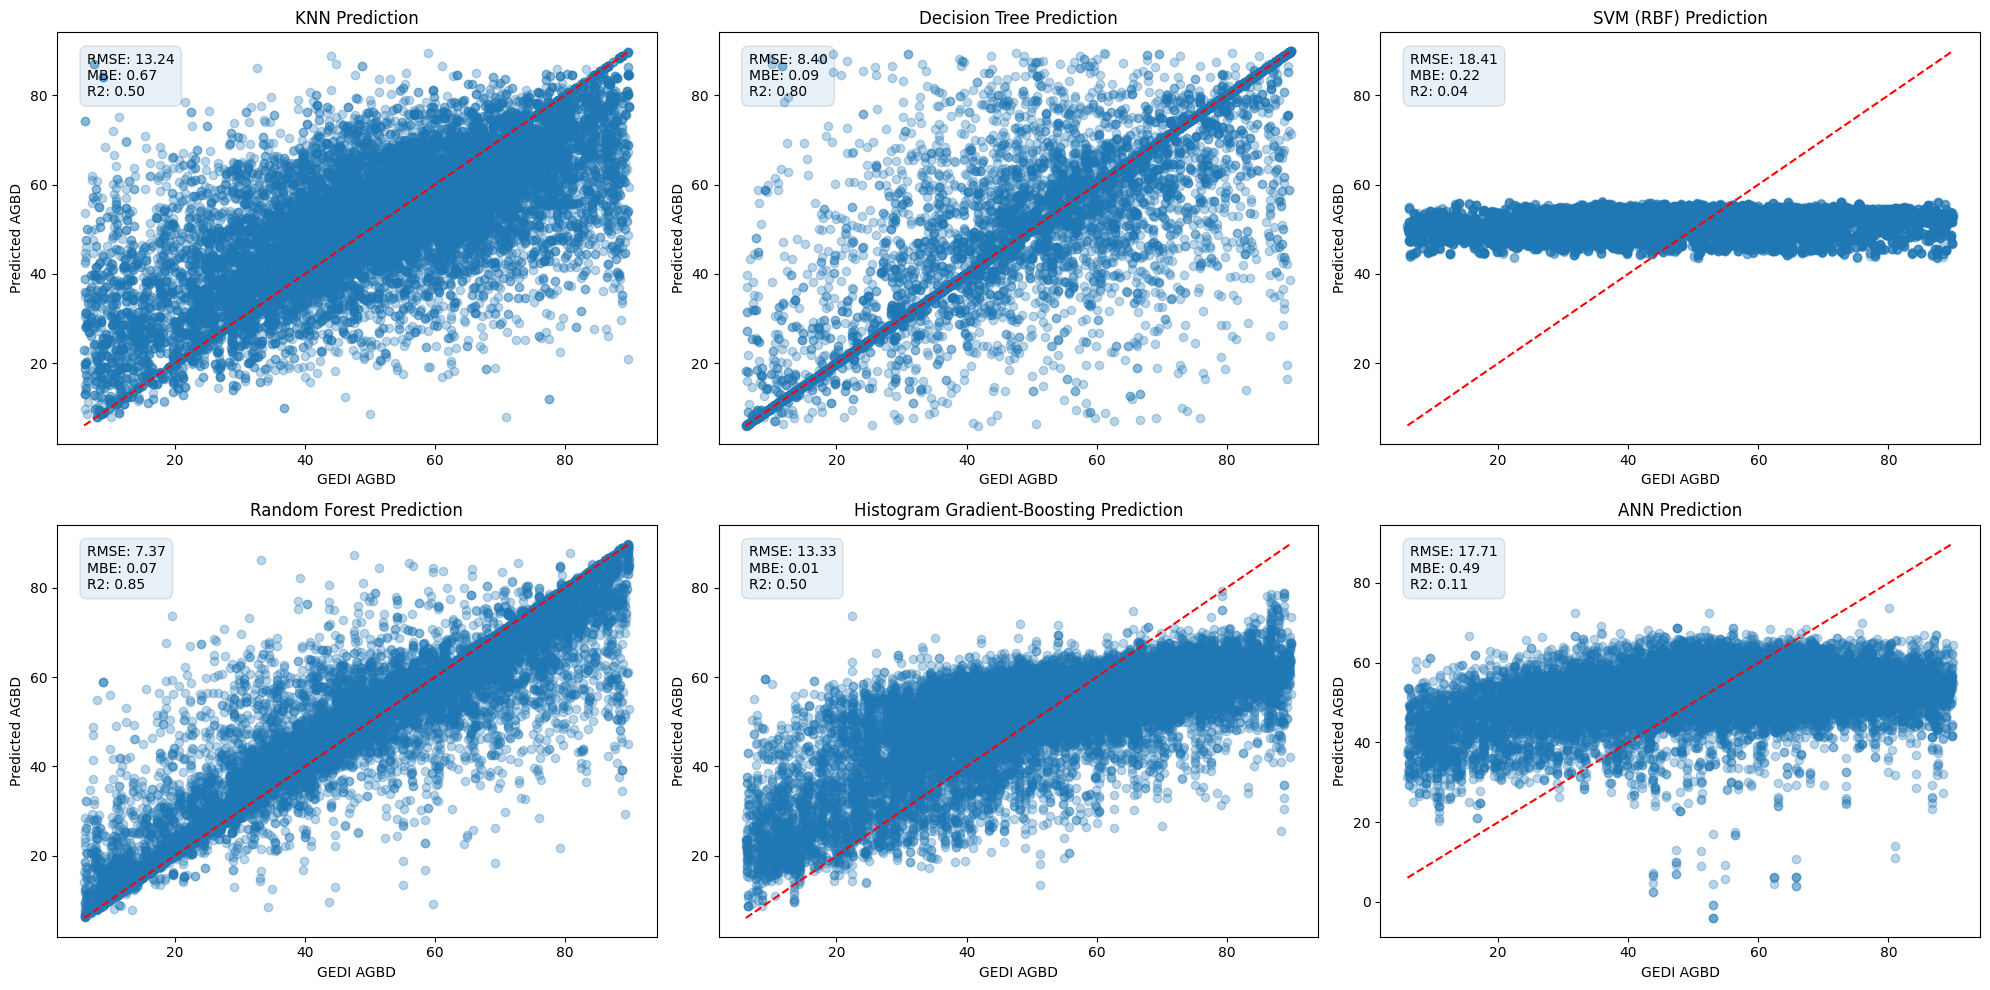

In [ ]:
# Plot the predicted vs. GEDI AGBD for each model
plt.figure(figsize=(20, 10))
for i, (model_name, model) in enumerate(models.items()):
    plt.subplot(2, 3, i + 1)
    y_pred = cross_val_predict(model, X_train, y_train, cv=10, n_jobs=-1)
    plt.scatter(y_train, y_pred, alpha=0.3)
    plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
    plt.xlabel('GEDI AGBD')
    plt.ylabel('Predicted AGBD')
    plt.title(f'{model_name} Prediction')

    # Get the metrics for the current model
    rmse, mbe, r2 = model_metrics[model_name]['RMSE'], model_metrics[model_name]['MBE'], model_metrics[model_name]['R2']

    # Display the metrics on the plot
    plt.text(0.05, 0.95, f'RMSE: {rmse:.2f}\nMBE: {mbe:.2f}\nR2: {r2:.2f}', transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', alpha=0.1))

plt.tight_layout()
plt.show()

We want to gain deeper insights into the relationship between predictor variables with the target variable 'agbd' (AGBD in Mg/ ha) for the RF model. We will compare the reference and predicted AGBD through scatter plots.

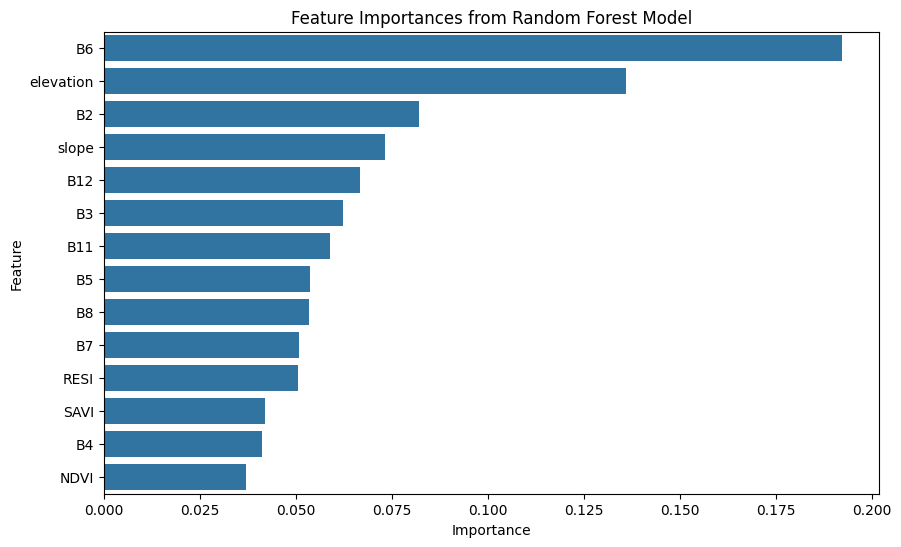

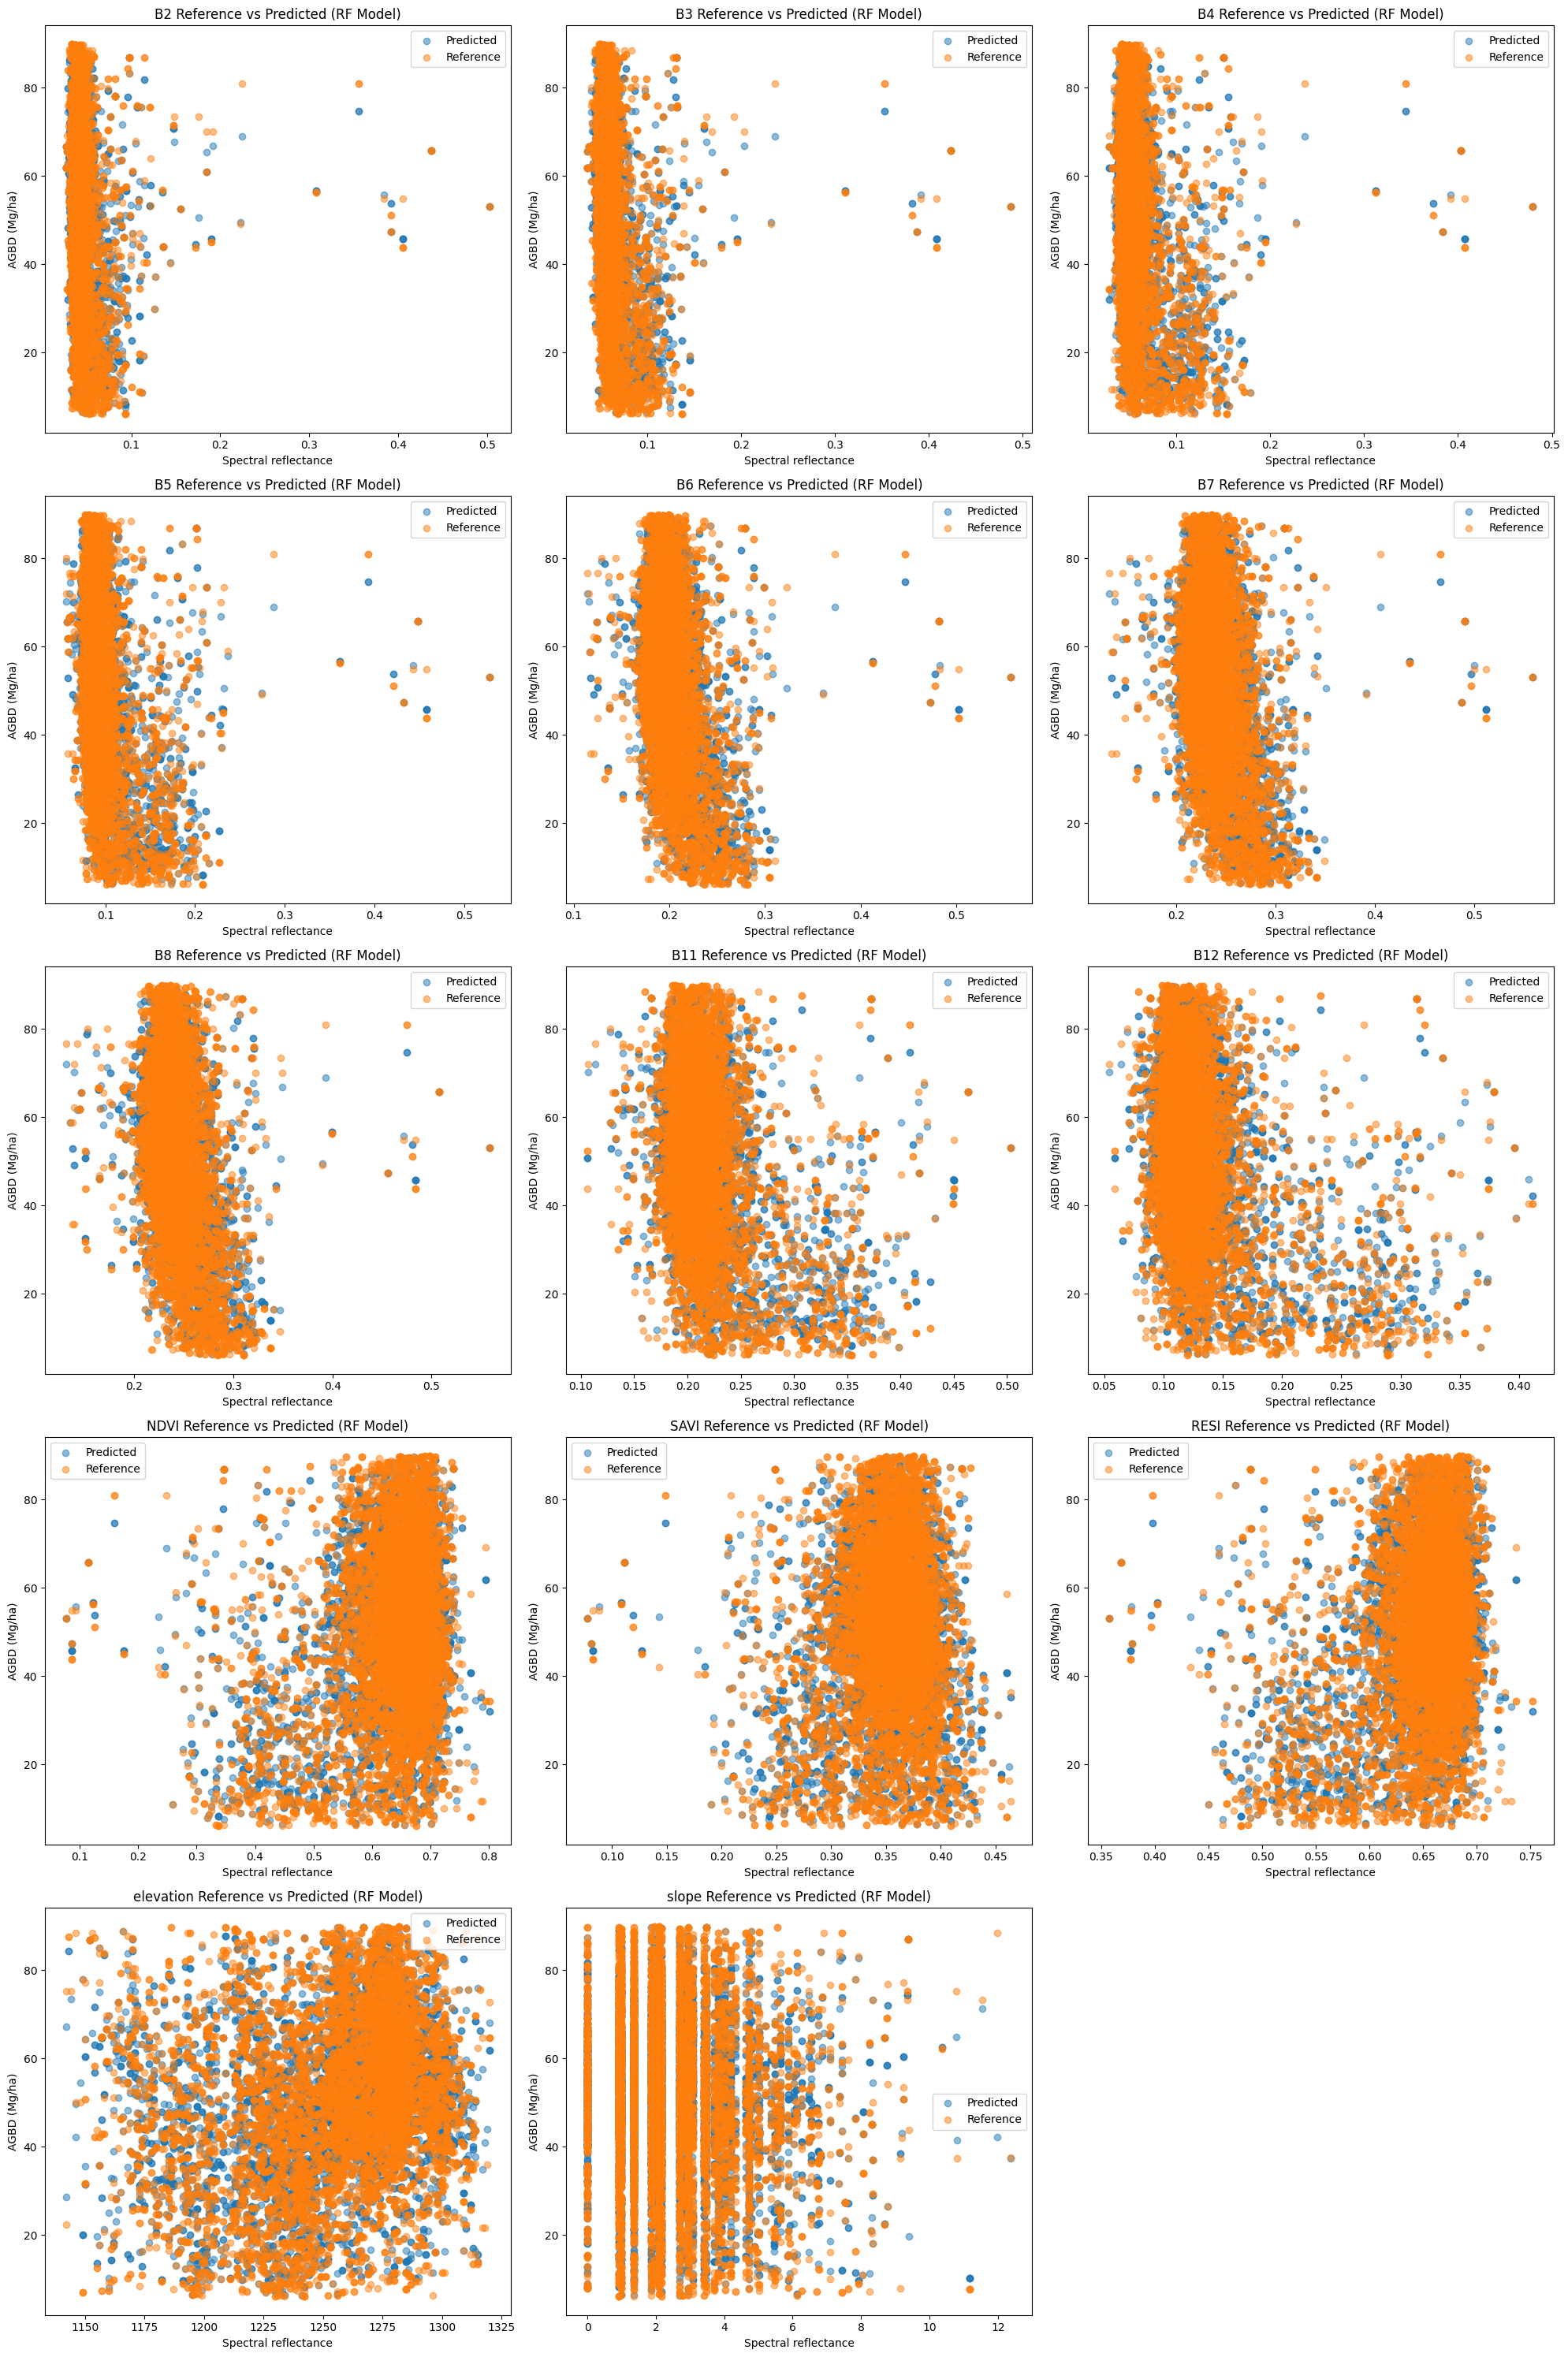

Feature importances:
       Feature  Importance
4          B6    0.192054
12  elevation    0.135926
0          B2    0.082016
13      slope    0.073217
8         B12    0.066637
1          B3    0.062331
7         B11    0.058976
3          B5    0.053709
6          B8    0.053530
5          B7    0.050791
11       RESI    0.050592
10       SAVI    0.041907
2          B4    0.041241
9        NDVI    0.037072


In [ ]:
# Train the Random Forest model on the entire training set
rf_model = RandomForestRegressor(random_state=27)
rf_model.fit(X_train, y_train)

# Compute feature importances
feature_importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': predictor_vars, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest Model')
plt.show()

# Predict on the test set
y_pred_test = rf_model.predict(X_test)

# Scatter plots of predicted AGBD vs. reference AGBD for each predictor variable
plt.figure(figsize=(20, 30))
for i, predictor in enumerate(predictor_vars):
    plt.subplot(5, 3, i+1)
    plt.scatter(X_test[predictor], y_pred_test, alpha=0.5, label='Predicted')
    plt.scatter(X_test[predictor], y_test, alpha=0.5, label='Reference')
    plt.xlabel('Spectral reflectance')
    plt.ylabel('AGBD (Mg/ha)')
    plt.title(f'{predictor} Reference vs Predicted (RF Model)')
    plt.legend()
plt.tight_layout()
plt.show()

# Analyze feature importances and scatter plots to understand the relationship
print("Feature importances:\n", importance_df)

We want to gain deeper insights into the relationship between predictor variables with the target variable 'agbd' (AGBD in Mg/ ha) for the SVR model. We will compare the reference and predicted AGBD through scatter plots.

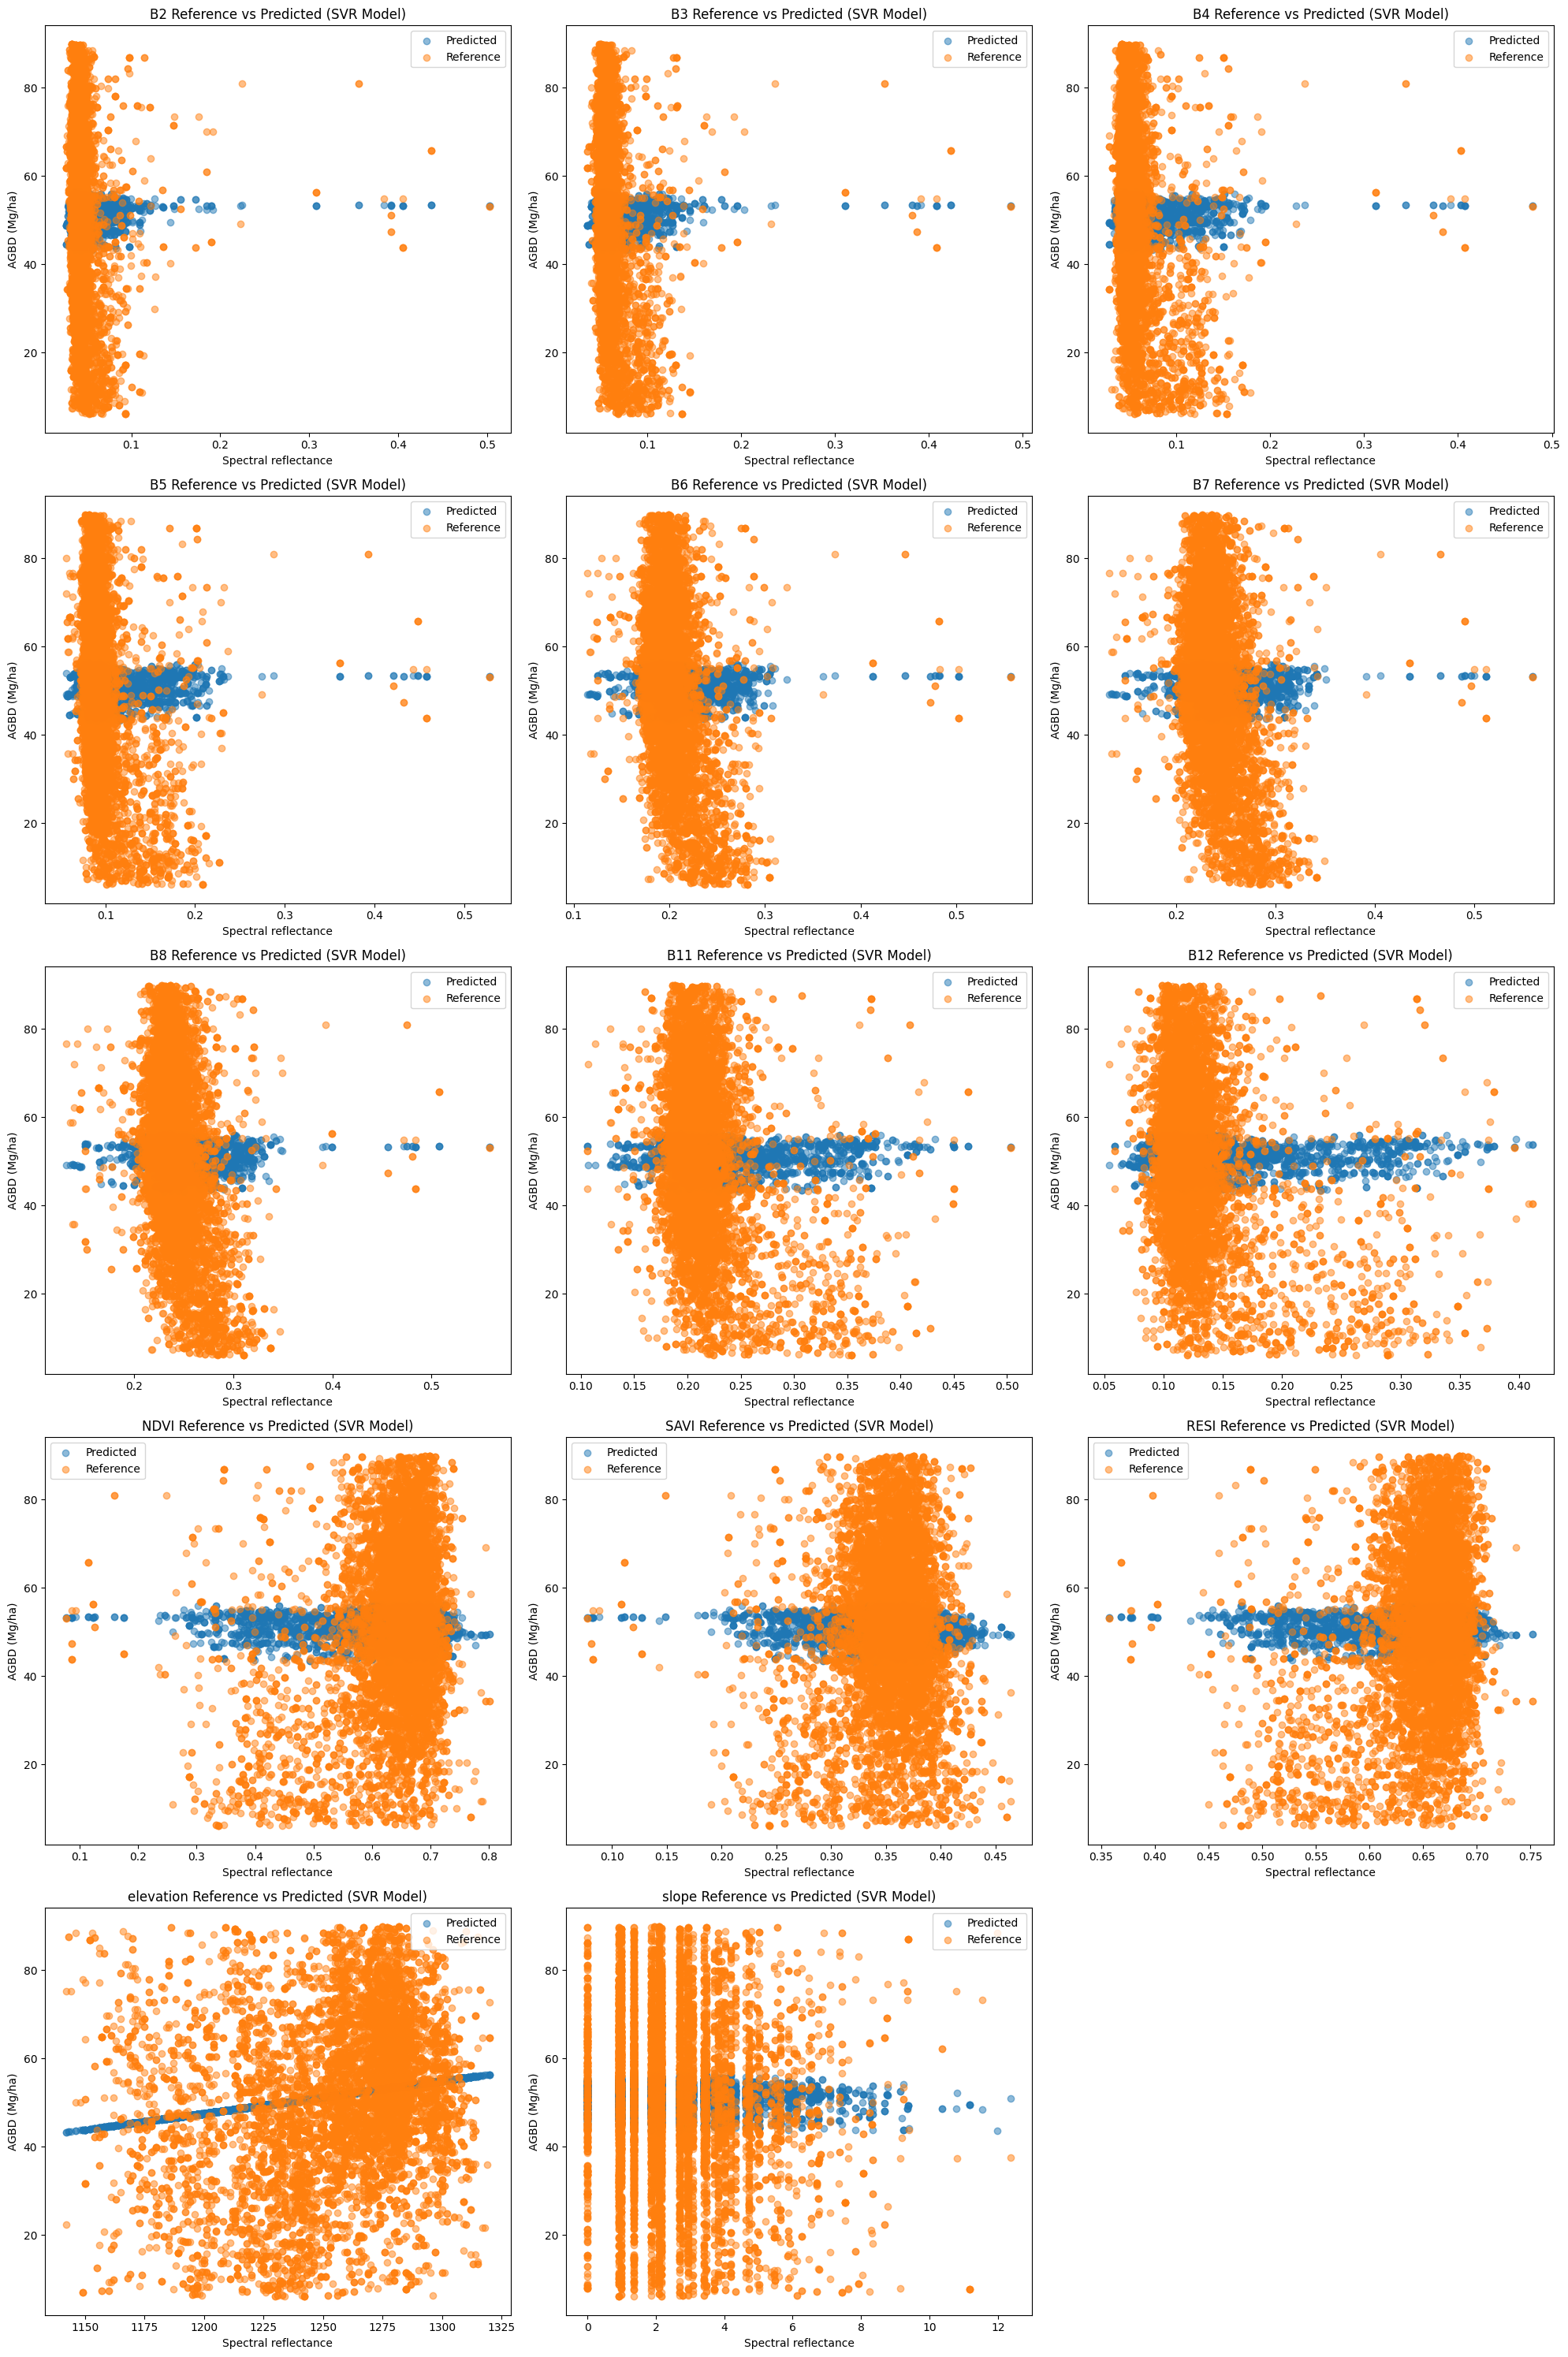

In [ ]:
# Train the SVR model on the entire training set
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_test = svr_model.predict(X_test)

# Scatter plots of predicted AGBD vs. reference AGBD for each predictor variable
plt.figure(figsize=(20, 30))
for i, predictor in enumerate(predictor_vars):
    plt.subplot(5, 3, i+1)
    plt.scatter(X_test[predictor], y_pred_test, alpha=0.5, label='Predicted')
    plt.scatter(X_test[predictor], y_test, alpha=0.5, label='Reference')
    plt.xlabel('Spectral reflectance')
    plt.ylabel('AGBD (Mg/ha)')
    plt.title(f'{predictor} Reference vs Predicted (SVR Model)')
    plt.legend()
plt.tight_layout()
plt.show()

## Train Models and Predict AGBD
We will train multiple regression models to predict AGBD. First, we begin by initializing an empty dictionary, model_predictions, to keep track of the predictions made by each model. Additionally, we use a 'SimpleImputer' with a strategy to fill missing values using the mean is created.

For each model in the models dictionary, the script constructs a pipeline that first handles missing values using the imputer and then applies the model. This pipeline is then fitted to the training data (X_train and y_train). After training, the pipeline predicts AGBD for the entire dataset (X).

The predictions for each model are added to the data DataFrame as new columns, with the column names indicating the respective models (e.g., 'KNN_pred', 'Decision Tree_pred'). These predictions are also stored in the model_predictions dictionary for further use or analysis. This process ensures that each model's predictions are readily accessible and organized within both the DataFrame and the dictionary.

In [ ]:
# Train models and predict AGBD
model_predictions = {}

# Imputer to fill missing values
imputer = SimpleImputer(strategy='mean')

for model_name, model in models.items():
    # Create a pipeline to handle missing values
    pipeline = make_pipeline(imputer, model)

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict AGBD for the whole dataset (X)
    y_pred_full = pipeline.predict(X)

    # Add predictions to the DataFrame
    data[f'{model_name}_pred'] = y_pred_full

    # Store predictions in dictionary
    model_predictions[model_name] = y_pred_full

## Predict and Visualize AGBD for Each Model
### Function to reshape and visualize predictions
Next, we will define a function named 'reshape_and_plot' that reshapes model predictions into the original image shape and visualizes them. The function takes three parameters: predictions (the predicted AGBD values), model_name (the name of the model used for the predictions), and shape (the original shape of the image).

Within the function, the predictions are reshaped to match the original image dimensions using the reshape method. A figure is then created with a specified size using plt.figure(figsize=plot_size), and a title is set to indicate the model used for the predictions. The reshaped predictions are plotted using the ep.plot_bands function with a color map ('YlGn') suitable for visualizing biomass density, and the figure size is adjusted accordingly. Finally, the plot is displayed with plt.show(), providing a visual representation of the predicted AGBD values as an image.

In [ ]:
# Define a function to reshape and visualize predictions
def reshape_and_plot(predictions, model_name, shape):
    # Reshape predictions to the original image shape
    prediction_reshaped = predictions.reshape(shape)

    # Plot the predictions
    plt.figure(figsize=plot_size)
    plt.title(f'Predicted AGBD ({model_name})')
    ep.plot_bands(prediction_reshaped, cmap='YlGn', scale=False, cbar=True, figsize=plot_size, vmin=0, vmax=90) # Set appropriate vmin and vmax
    plt.show()

### Predict and visualize AGBD for each model
Finnaly, let's predict and display AGBD from each model. Initially, prepare the input data from an image with multiple bands. For each band, the script reads the band data using image.read(x + 1) and appends it to the image_input list. After reading all the bands, it stacks them into a single array using np.stack and reshapes the data into a format suitable for model input (with dimensions bandNum by the number of pixels, and then transposes it).

Next, we want to handle any missing values (NaNs) in the image input by applying an imputer (imputer.fit_transform(image_input)) that fills missing values with the mean.

The script then iterates through each model in the models dictionary. For each model, it predicts the Aboveground Biomass Density (AGBD) using the preprocessed image input (pipeline.predict(image_input)). The predictions are scaled by multiplying by 450 (to adjust the units if necessary).

Finally, we can call the reshape_and_plot function to reshape the predictions back to the original image shape and visualize the results. This function generates a plot for each model, showing the predicted AGBD values as an image, facilitating a comparison of the model outputs.

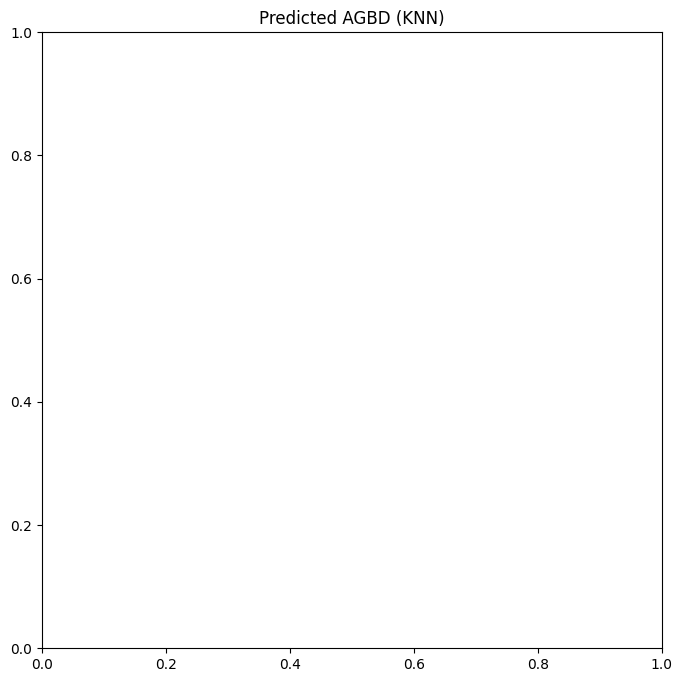

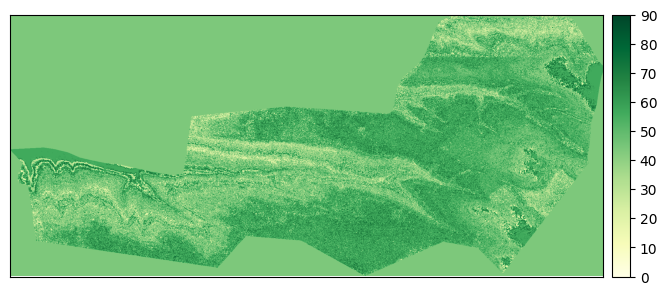

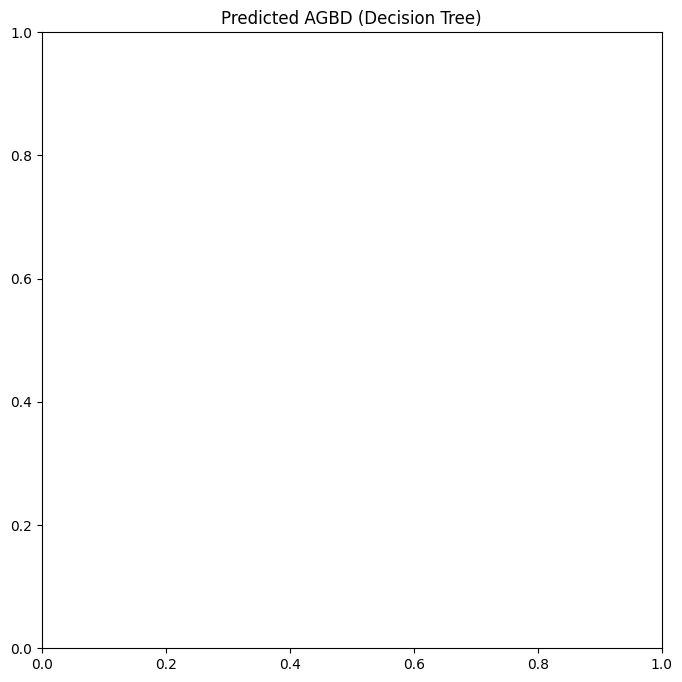

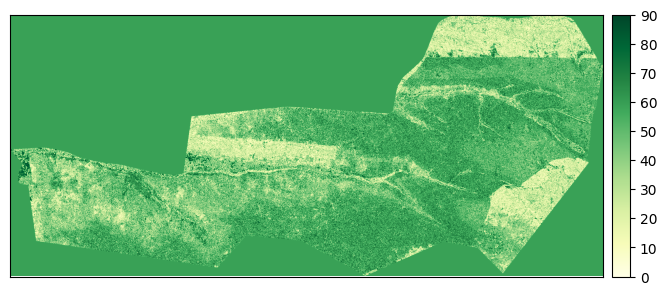

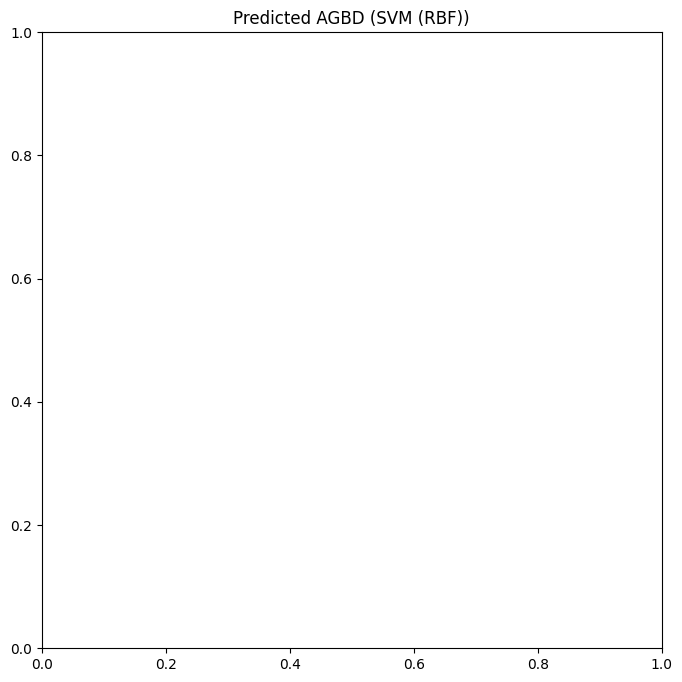

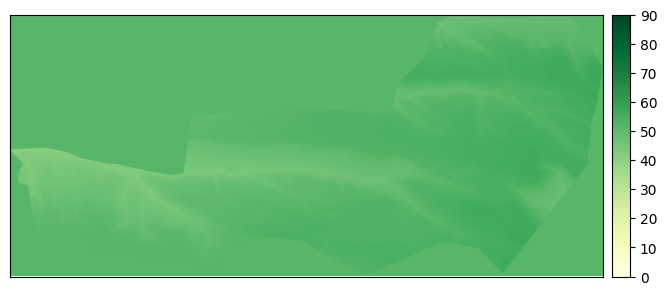

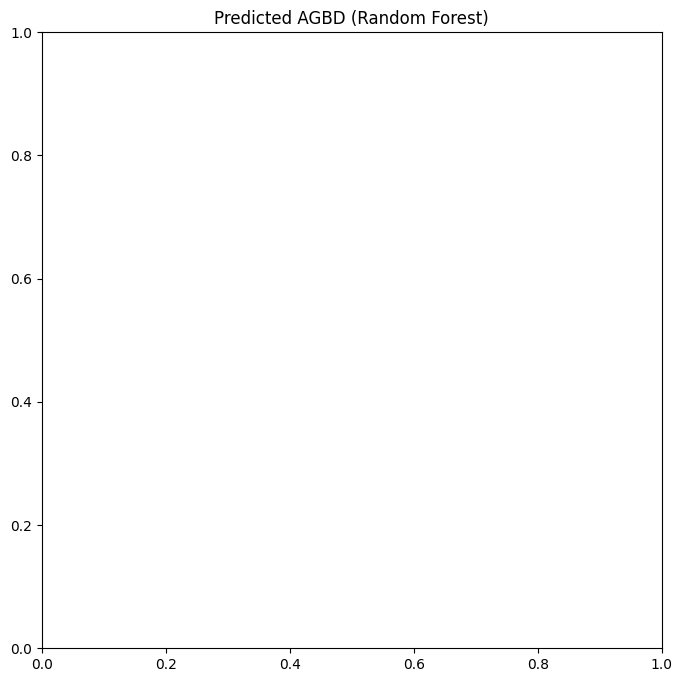

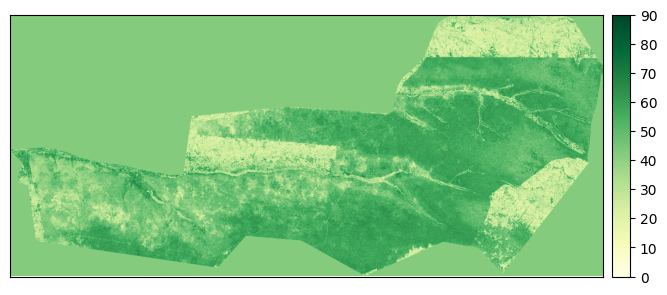

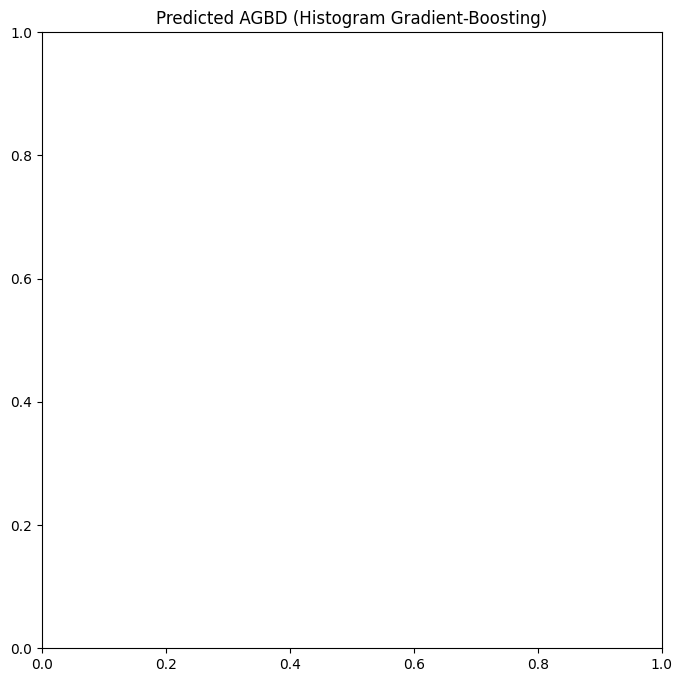

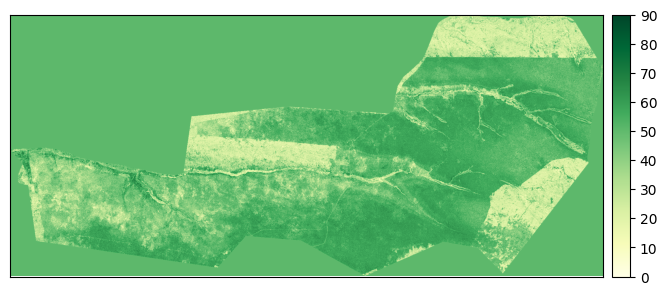

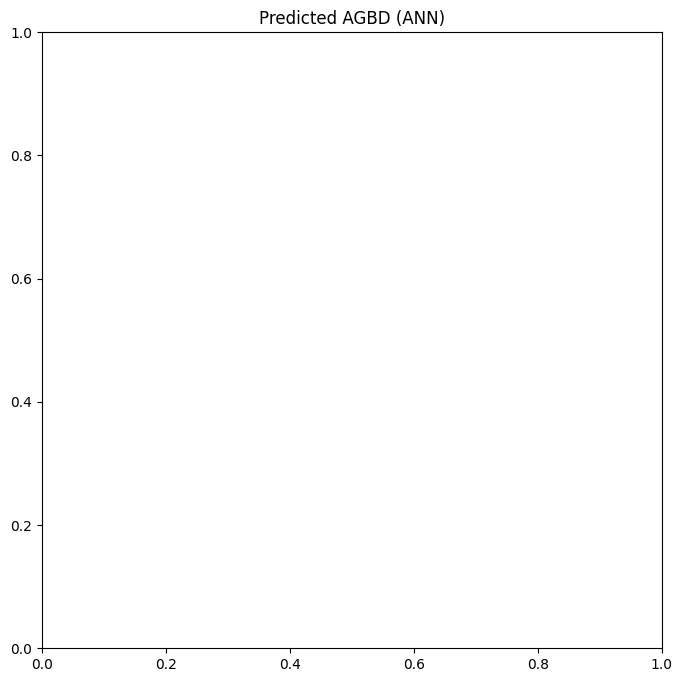

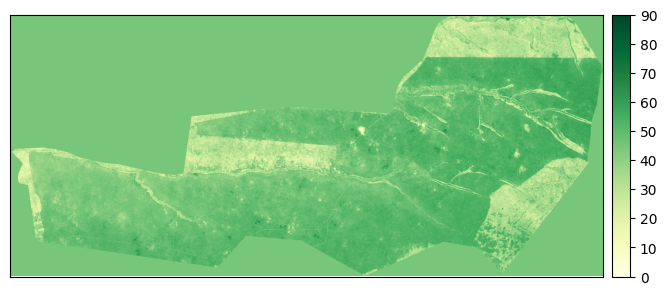

In [ ]:
# Predict image using the model
image_input = []
for x in range(bandNum):
    image_input.append(image.read(x + 1))
image_input = np.stack(image_input).reshape(bandNum, -1).T

# Handle NaNs in image input
image_input = imputer.fit_transform(image_input)

# Predict and visualize for each model
for model_name, model in models.items():
    pipeline = make_pipeline(imputer, model)
    predictions = pipeline.predict(image_input)
    reshape_and_plot(predictions, model_name, shape)

## Key Takeaways
In machine learning and optimization, the "no free lunch" therorem suggests that there is no universally best algorithm for solving all optimization and machine learning problems (Wolpert and Macready, 1997). A machine learning method or algorithm that performs well on one class of problems may perform poorly on another. That is, every method has assumptions. If these assumptions are not met, the results can be unreliable. While there is rapid advancement in machine learning, it is also important to remember that more complicated and advanced methods or algorithms are not always better. Using data-centric approaches and other techniques like regularization and cross-validation can significantly improve standard methods in some cases.


In this tutorial, we observed that the random forest model outperforms the other models in predicting aboveground biomass density (AGBD). The performance metrics evaluated include root meansSquareeError (RMSE), mean bias error (MBE), and the coefficient of determination (R²). The random forest model has the lowest RMSE of 7.371607, indicating the smallest average prediction error among the models. It also has a low MBE of 0.071307, suggesting minimal bias in its predictions. Additionally, it achieves the highest R² value of 0.846258, indicating that it explains the largest proportion of the variance in the true AGBD values.


In comparison, the K-nearest neighbors (KNN) model has a higher RMSE (13.238956) and a moderate R² (0.504122), while the decision tree model shows a better RMSE (8.401357) but still lower than Random Forest and a decent R² (0.800306). The SVM with RBF kernel has the highest RMSE (18.409324) and a very low R² (0.041168), indicating poor performance. The histogram gradient-boosting model has an RMSE similar to KNN (13.325970) and an R² comparable to KNN (0.497583). Overall, the Random Forest model is the most accurate and reliable among the evaluated models for this task.

In the next tutorial, we will focus on the random forest model, which is the best model. We will perform an exploratory data analsyis to understand the training data. We will also use explainable machine learning methods to gain insights into the random forest model results.


## References
Wolpert, D. H., & Macready, W. G. (1997). No free lunch theorems for optimization. IEEE Transactions on Evolutionary Computation, 1(1), 67–82. https://doi.org/10.1109/4235.585893


In [ ]:
! jupyter nbconvert --to html 3b_Modeling_AGBD_GEDI_S2_SpectralIndices_MafungautsiForestReserve_29_July_2024_Comparison_ML_RegressorsTutorial_Scikit_Learn_Final.ipyn